In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [3]:
Features = pd.read_csv("feature.csv") 
Features.head()
Features

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.300781,0.706492,0.756853,0.735217,0.731014,0.715156,0.667529,0.673754,0.722173,0.748969,...,4.319263e-06,0.000003,0.000002,2.286677e-06,5.131694e-06,8.065748e-06,0.000005,2.270858e-06,1.642365e-07,neutral
1,0.313825,0.778948,0.819544,0.798489,0.809550,0.817168,0.714585,0.684880,0.729729,0.764166,...,4.554279e-05,0.000044,0.000045,4.419856e-05,4.638837e-05,4.941625e-05,0.000049,4.440693e-05,4.473549e-05,neutral
2,0.176693,0.640605,0.712837,0.743736,0.714797,0.701402,0.694569,0.663853,0.688527,0.742508,...,7.999367e-07,0.000001,0.000001,5.350822e-07,3.480662e-07,8.398366e-07,0.000001,4.287777e-07,2.878995e-08,neutral
3,0.271272,0.674966,0.723259,0.724594,0.681302,0.670643,0.674574,0.630036,0.680146,0.708276,...,6.998011e-06,0.000007,0.000007,6.999257e-06,1.217880e-05,9.449916e-06,0.000008,2.638513e-06,1.788902e-07,neutral
4,0.281146,0.753292,0.786662,0.758819,0.746537,0.757187,0.689647,0.641518,0.696482,0.726075,...,1.357192e-05,0.000014,0.000014,1.464036e-05,1.883595e-05,1.696650e-05,0.000016,9.794435e-06,7.203743e-06,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15751,0.056647,0.400899,0.363842,0.288446,0.316558,0.318172,0.413583,0.493970,0.453717,0.563200,...,4.161627e-05,0.000043,0.000068,6.600720e-05,8.382198e-05,5.549716e-05,0.000031,1.663076e-05,1.228124e-05,sad
15752,0.043530,0.305641,0.400549,0.326697,0.252641,0.296804,0.285628,0.434680,0.470216,0.430742,...,1.236520e-05,0.000010,0.000011,1.594945e-05,2.725638e-05,2.512380e-05,0.000019,6.173988e-06,3.485156e-06,sad
15753,0.082564,0.429035,0.467454,0.366867,0.379050,0.359398,0.427272,0.481370,0.480836,0.592812,...,1.479005e-04,0.000162,0.000151,1.814116e-04,1.816919e-04,1.122789e-04,0.000074,2.171396e-05,2.901469e-06,sad
15754,0.129566,0.461756,0.522920,0.450084,0.442755,0.436089,0.485292,0.525965,0.505999,0.619472,...,4.522038e-04,0.000443,0.000442,4.899041e-04,4.912984e-04,3.930559e-04,0.000369,3.202054e-04,3.115559e-04,sad


### Data Preparation ###

In [4]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [5]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
Y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [6]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((11817, 162), (11817, 8), (3939, 162), (3939, 8))

In [7]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((11817, 162), (11817, 8), (3939, 162), (3939, 8))

In [8]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((11817, 162, 1), (11817, 8), (3939, 162, 1), (3939, 8))

In [9]:
import tensorflow as tf

In [10]:
new_model = tf.keras.models.load_model('CNN_model.h5')

In [11]:
# predicting on test data.
pred_test = new_model.predict(x_test)
pred_test

array([[1.22706255e-17, 4.12448254e-19, 7.71783240e-22, ...,
        1.00000000e+00, 9.73126646e-09, 2.12927175e-21],
       [7.26755411e-09, 9.96703088e-01, 2.52429744e-09, ...,
        6.42531886e-05, 2.02754932e-03, 4.04942009e-12],
       [3.00525135e-04, 8.24267864e-01, 4.66609548e-04, ...,
        2.66498774e-02, 9.08464417e-02, 3.23855384e-05],
       ...,
       [1.00000000e+00, 0.00000000e+00, 4.60647888e-19, ...,
        4.80584622e-35, 2.30598100e-23, 1.57206019e-26],
       [1.78698767e-09, 9.93960619e-01, 5.60656935e-13, ...,
        4.92420213e-07, 4.27847845e-05, 9.27573414e-15],
       [1.40521383e-09, 5.14347586e-15, 9.99999404e-01, ...,
        1.54366472e-12, 1.92018120e-11, 6.30964109e-07]], dtype=float32)

In [12]:
y_pred = encoder.inverse_transform(pred_test)

In [13]:
y_test = encoder.inverse_transform(y_test)


In [14]:
#check out the results on un seen data prediction 
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,neutral,neutral
1,calm,calm
2,calm,calm
3,neutral,neutral
4,fear,disgust
5,sad,sad
6,disgust,disgust
7,fear,fear
8,sad,sad
9,surprise,surprise


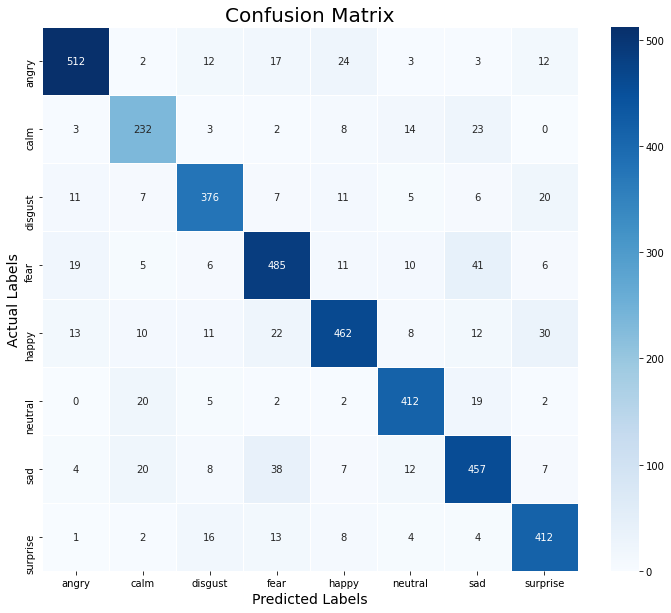

In [15]:
# the true positive and true negative are dark in colour= corect pred
#the other lighter boxes are  fals positive and false negative = wrong pred
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [16]:
# creating the report of model traning accuracy for each labels 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.91      0.88      0.89       585
        calm       0.78      0.81      0.80       285
     disgust       0.86      0.85      0.85       443
        fear       0.83      0.83      0.83       583
       happy       0.87      0.81      0.84       568
     neutral       0.88      0.89      0.89       462
         sad       0.81      0.83      0.82       553
    surprise       0.84      0.90      0.87       460

    accuracy                           0.85      3939
   macro avg       0.85      0.85      0.85      3939
weighted avg       0.85      0.85      0.85      3939



In [17]:
from pydub import AudioSegment
import wave
import os
import numpy as np
import librosa
import math
import contextlib

## to test another audio just bring the file in folder where code is present and change the Fname in below cell

In [18]:
#here for the better animation we have splited the file in 1 sec segments and ploting the segments as 1 fps
# loading the input audio file for spliting it into 3 sec  segments and saving it into the folder newAudio 
# it only accepts .wav files so if you have .mp3 convert it into .wav and add it into the same folder where is ipynb file
fname = 'my_result.wav'
with contextlib.closing(wave.open(fname,'r')) as f:
    frames = f.getnframes()
    rate = f.getframerate()
    duration = frames / float(rate)
Audio = AudioSegment.from_wav(fname)
# Segmenting the audio file to small files of length 1 sec
duration = math.floor(duration)
for i in range(duration):
  newAudio = Audio[i*1000:(i+1)*1000]
  newAudio.export('./audio/'+str(i)+'.wav', format="wav")

In [19]:
# path to save segmented audio 
newAudio='.\\audio\\'

In [20]:
# making dataframe of audio files with there path location . 
newAudio_directory_list = os.listdir(newAudio)
file_path = []

for file in newAudio_directory_list:
    file_path.append(newAudio + file)

# dataframe for path of files.
data_path = pd.DataFrame(file_path, columns=['Path'])

In [21]:
x = []
for path, in zip(data_path.Path,):
    data, sample_rate = librosa.load(path)
    x.append(extract_features(data))
    

In [22]:
# converting the features  array to data frame and saving it as csv file
Feature = pd.DataFrame(x)

In [23]:
x_ = Feature.values

In [24]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_ = scaler.fit_transform(x_)

In [25]:
# Add a new dimention to the features array to be used by the cnn model
x_ = np.expand_dims(x_, axis=2)
y = new_model.predict(x_)

In [26]:
y_pred = encoder.inverse_transform(y)

In [27]:
pre_newAudio= y.tolist()

In [28]:
import math
import matplotlib.pyplot as plt
from matplotlib import animation
import moviepy.editor as mp
import contextlib

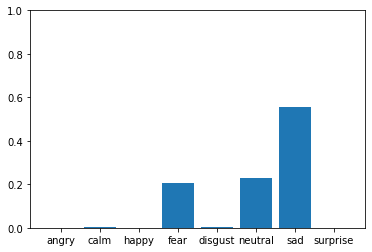

In [29]:
#Creating the animation
fig=plt.figure()

n=duration
#Number of frames
x=['angry', 'calm', 'happy', 'fear', 'disgust', 'neutral', 'sad','surprise']
barcollection = plt.bar(x,[0,0,0,0,0,0,0,0])
plt.ylim([0,1])
def animate(i):
    y=pre_newAudio[i]
    for i, b in enumerate(barcollection):
        b.set_height(y[i])
anim=animation.FuncAnimation(fig,animate,repeat=False,blit=False,frames=n)

anim.save('mymovie.mp4',writer=animation.FFMpegWriter(fps=1))
plt.show()
# this plot is not ploted correct bcs jupyter does not  support the requirments .
# just visit to the file named output and see the animated results.

# # rename the audio clip here also as same as in fname in above .
## change the name of audio file here also-- audio = mp.AudioFileClip("House_of_Commons_06-09-17_12-38-24.mp3")


In [30]:
#Merging the animation with the audio
audio = mp.AudioFileClip("my_result.mp3")
video1 = mp.VideoFileClip('mymovie.mp4')
final = video1.set_audio(audio)
final.write_videofile("output2.mp4",codec= 'mpeg4' ,audio_codec='libvorbis')

chunk:   0%|          | 0/502 [00:00<?, ?it/s, now=None]

Moviepy - Building video output1.mp4.
MoviePy - Writing audio in output1TEMP_MPY_wvf_snd.ogg


t:   0%|          | 0/22 [00:00<?, ?it/s, now=None]                 

MoviePy - Done.
Moviepy - Writing video output1.mp4



Moviepy - Done !
Moviepy - video ready output1.mp4


In [31]:
import os, re, os.path
mypath = "audio"
for root, dirs, files in os.walk(mypath):
    for file in files:
        os.remove(os.path.join(root, file))

## play the file output.mp4 in players like VLC and MX .